# Data Analysis of Olivocerebellar Model

## Table of Contents
### 1. Import All
    1. Import packages
    2. Import data of simulations
### 2. Split Data - Before/After Adaptation
### 3. Purkinje Cell 
    1. Input current
    2. 
### 4. Inferior Olive
    1.
### 5. Correlations/Delays
    1. IO - IO 
### 6. Complex Spike Analysis
    1. PC current input
    2. Voltage of IO cell
    

## 1. Import All

In [11]:
# 1.1) Import packages
import numpy as np
from importlib import reload
from brian2 import*
import pickle
import NeuroTools as nt
from NeuroTools import signals, analysis
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import scipy.io as sio
import seaborn as sns
import matplotlib.patches as mpatches
#import plotpy.express as px

# Import and reload my helpers module for iterative development
import helpers
reload(helpers)
from helpers.Function_DataAnalysis import *

# default dict. to assign values
from collections import defaultdict

with open('PV.pickle', 'rb') as par:
    PV = pickle.load(par)
with open('SpikeTimes.pickle', 'rb') as st:
    SpikeTimes = pickle.load(st)
with open('VoltCell.pickle', 'rb') as vc:
    VoltCell = pickle.load(vc)
with open('Input.pickle', 'rb') as inp:
    Input = pickle.load(inp)
#print(PV['a_PC'][1])
# 1.2) Import data of simulations
#nameInput = 'InputDS_5Diff'
#name_simparam = nameInput + '_SimParams'
#name_VoltCell = nameInput + '_VoltageCell'
#name_SpikeT = nameInput + '_SpikeTimes'
#name_PV = nameInput + '_PlasticityVariables'
#name_Input = nameInput + 'AfterSim'

#SimParam = sio.loadmat(name_simparam)
#VoltCell = sio.loadmat(name_VoltCell)
#SpikeTimes = sio.loadmat(name_SpikeT)
#PlasticityVar = sio.loadmat(name_PV)
#Input = sio.loadmat(name_Input)


## 2. Split Data - Before/After Adaptation

In [12]:
# 2) Split Data - before/after adaptation    

# before = start_t:t_beforeAdaptation
# after = t_beforeAdaptaion:end
# indicated by BA (BeforeAdaptation) and AA (AfterAdaptation) accordingly


start = 1000 # remove first second of data due to transient
t_beforeAdaptation = int(len(Input['I'][1])/2)


#int(len(Input['Input']['I'][0][0][0])/2) # halfway the simulation
nrInputs=Input['I'].shape[0] # number of inputs
print(nrInputs)
nrPC = VoltCell['PC'].shape[0]
nrDCN = VoltCell['DCN'].shape[0]
nrIO = VoltCell['IOsoma'].shape[0]
nrDummy = nrPC*nrInputs
lengthSim =VoltCell['PC'].shape[1]
print(start,t_beforeAdaptation)
BeforeAdaptation = {}
# Input to the system
Input = Slicing(Input, t_start=start)
Input_BA = Slicing(Input, t_start=start, t_end=t_beforeAdaptation)
Input_AA = Slicing(Input, t_start=t_beforeAdaptation)

# Voltages of Cells
VoltCell_ = Slicing(VoltCell, t_start=start)
VoltCell_BA = Slicing(VoltCell, t_start=start, t_end=t_beforeAdaptation)
VoltCell_AA = Slicing(VoltCell, t_start=t_beforeAdaptation)
print(VoltCell['IOsoma'][1])
for k in range(0,nrIO):
    #IOnr = 'IO'+str(k)
    findspikes, _ = find_peaks(VoltCell['IOsoma'][k], height=0.0, distance = 10) 
    findspikes = findspikes/1000
    SpikeTimes['IO'][k]=findspikes
# Slicing spike times
SpikeTimes_BA = SlicingSpikes(SpikeTimes, t_start=start/1e3, t_end=t_beforeAdaptation/1e3)
SpikeTimes_AA = SlicingSpikes(SpikeTimes, t_start=t_beforeAdaptation/1e3)
#findspikes, _ = find_peaks(VoltCell['VoltCell']['IOsoma'][0][0][p], height=0.0, distance = 10)
#findspikes = findspikes/1000
print(SpikeTimes_BA['IO'][9])
print('io spike time[ms]',SpikeTimes_BA['IO'][4])

5
1000 25000
[  0.         -41.37986549 -37.16348396 ... -72.55261277 -72.68898828
 -72.73561103] mV
[ 1.214  1.453  1.72   1.958  2.219  2.458  2.708  2.951  3.227  3.47
  3.721  3.959  4.217  4.459  4.717  4.957  5.215  5.455  5.72   5.959
  6.211  6.456  6.714  6.955  7.214  7.453  7.717  7.958  8.201  8.451
  8.709  8.948  9.218  9.459  9.702  9.95  10.203 10.448 10.698 10.947
 11.206 11.455 11.716 11.991 12.268 12.525 12.825 13.074 13.362 13.612
 13.867 14.102 14.383 14.626 14.887 15.14  15.41  15.661 15.916 16.156
 16.41  16.652 16.902 17.152 17.417 17.674 17.943 18.205 18.464 18.742
 18.998 19.284 19.534 19.807 20.055 20.334 20.58  20.868 21.112 21.394
 21.644 21.924 22.176 22.439 22.689 22.956 23.212 23.455 23.712 23.959
 24.204 24.462 24.726 24.981]
io spike time[ms] [ 1.226  1.504  1.972  2.234  2.608  2.96   3.244  3.617  3.938  4.209
  4.486  4.978  5.216  5.486  5.974  6.214  6.501  7.109  7.442  7.742
  8.117  8.488  8.7    8.996  9.613 10.095 10.447 10.707 11.049 11.572


### 3. Purkinje Cell

In [3]:
# 3.1 Input current 

InputCurrentPC={}
InputCurrentPC_BA={}
InputCurrentPC_AA={}

for i in range(0,nrPC):
    # Create names for the inputs
    name = 'PC'+str(i)
    nameBA = 'PC'+str(i) + 'BA'
    nameAA = 'PC'+str(i) + 'AA'
    
    tot = name + 'total'
    totBA = nameBA + 'total'
    totAA = nameAA + 'total'
    # Connectivity between PC-dummy
    steps =np.arange(i,nrDummy,nrPC)
    # Multiply the current times the weight
    current = [Input['I'][k]*Input['nweight'][steps[k]] for k in range(0,len(steps))]
    currentBA = [Input_BA['I'][k]*Input_BA['nweight'][steps[k]] for k in range(0,len(steps))]
    currentAA = [Input_AA['I'][k]*Input_AA['nweight'][steps[k]] for k in range(0,len(steps))]
    #[Input_s.nweight_BA[steps[k]]*Input_s.I_BA[k] for k in range(0,len(steps))]
    #print(steps[1])
    #print(size(Input_s.nweight_BA[0]))
    #print(size(current))
    # Sum over the column to get the total amount of current
    summedcurrent = sum(current,axis=0)
    summedcurrentBA = sum(currentBA, axis=0)
    summedcurrentAA = sum(currentAA, axis=0)
    
    InputCurrentPC[name] = current
    InputCurrentPC_BA[nameBA] = currentBA
    InputCurrentPC_AA[nameAA] = currentAA
    
    InputCurrentPC[tot] = summedcurrent
    InputCurrentPC_BA[totBA] = summedcurrentBA
    InputCurrentPC_AA[totAA] = summedcurrentAA



### 5. Correlations

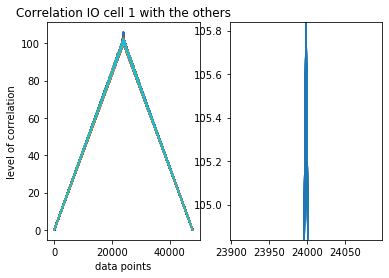

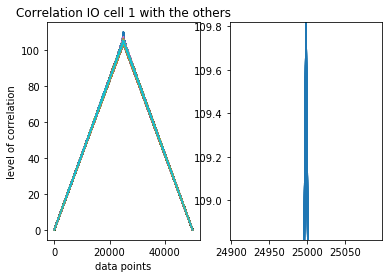

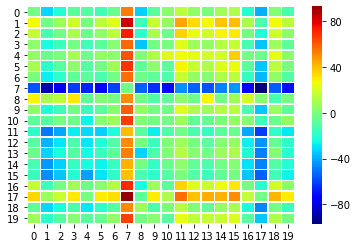

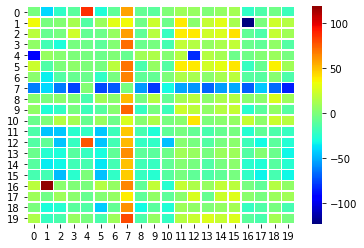

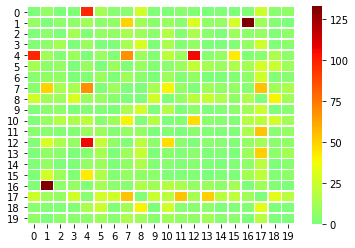

In [4]:
delayIO_BA = np.empty([nrIO,nrIO])
delayIO_AA = np.empty([nrIO,nrIO])
diffDelay = np.empty([nrIO,nrIO])
for i in range(0,nrIO):
    # Correlation Before Adapatation
    corr_BA=[correlate(VoltCell_BA['IOsoma'][i],VoltCell_BA['IOsoma'][k],'full') for k in range(0,nrIO)]
    corr_AA=[correlate(VoltCell_AA['IOsoma'][i],VoltCell_AA['IOsoma'][k],'full') for k in range(0,nrIO)]
    #print(corr_BA)
    #print(len(VoltCell_s.IOsoma_AA[i]))
    #lagIO_BA=numpy.where(corr_BA[i] == numpy.amax(corr_BA[i]))
    
    lagTotal_BA = [corr_BA[k].argmax()-len(VoltCell_BA['IOsoma'][i])-1 for k in range(0,nrIO)]
    lagTotal_AA = [corr_AA[k].argmax()-len(VoltCell_AA['IOsoma'][i])-1 for k in range(0,nrIO)]
    #print(lagTotal_AA)
    #lagTotal_BA = asarray([(asarray(lagRest_BA[k][0])-asarray(lagIO_BA[0][0])) for k in range(0,nrIO)])
    #lagTotal_BA = lagTotal_BA.reshape(nrIO)
    #print(lagIO_BA)
#print(lagRest_BA)
#print(lagTotal_BA)
    #lagIO_AA=numpy.where(corr_AA[i] == numpy.amax(corr_AA[i]))
    #lagRest_AA = [numpy.where(corr_AA[k] == numpy.amax(corr_AA[k])) for k in range(0,nrIO)]
    #lagTotal_AA = asarray([(asarray(lagRest_AA[k][0])-asarray(lagIO_AA[0][0])) for k in range(0,nrIO)])
    #lagTotal_AA = lagTotal_AA.reshape(nrIO)

    delayIO_BA[i] = lagTotal_BA
    delayIO_AA[i] = lagTotal_AA
    
    if i==0:
        plt.subplot(121)
        for l in range(0,nrIO):
            plt.plot(transpose(corr_BA))
        #print(len(corr_A[0]))
        #print(len(corr_BA))
        plt.title('Correlation IO cell 1 with the others')
        plt.xlabel('data points')
        plt.ylabel('level of correlation')
        ax1=plt.subplot(122)
        for l in range(0,nrIO):
            plt.plot(transpose(corr_BA))
        ax1.set_xlim([corr_BA[i].argmax()-100, corr_BA[i].argmax()+100])
        bmax=max(asarray(corr_BA[i]))
        ax1.set_ylim([bmax-1,bmax])
        plt.show()
        plt.subplot(121)
        for l in range(0,nrIO):
            plt.plot(transpose(corr_AA))
        #print(len(corr_A[0]))
        #print(len(corr_BA))
        plt.title('Correlation IO cell 1 with the others')
        plt.xlabel('data points')
        plt.ylabel('level of correlation')
        ax1=plt.subplot(122)
        for l in range(0,nrIO):
            plt.plot(transpose(corr_AA))
        ax1.set_xlim([corr_AA[i].argmax()-100, corr_AA[i].argmax()+100])
        amax=max(asarray(corr_AA[i]))
        ax1.set_ylim([amax-1,amax])       
            
            
    #print(lagTotal_AA[:])

    diffDelay[i] = abs(asarray(lagTotal_AA)-asarray(lagTotal_BA))


figure()
ax = sns.heatmap(delayIO_BA, center=0,cmap='jet',linewidths=.5)

figure()
sx = sns.heatmap(delayIO_AA, center=0, cmap='jet', linewidths=.5)

figure()
df = sns.heatmap(diffDelay,center=0, cmap='jet', linewidths=.5)


### 6. Complex Spike Analysis

In [6]:
# 6.1 Input Current Purkinje Cell
# Get the current that the Purkinje cell sees 150 ms before and 50 ms after
# a complex spike of the connected Inferior Olive

# The IO cells that are connected to the Purkinje cells. 
# Position 1 of the vector corresponds to PC1, 2 to PC2 etc.
connectionVectorIO = [9,10, 18, 17, 0, 6, 5, 12, 16, 11]

time_before_spike = 150e-3
time_after_spike = 50e-3
CS_currentPC=defaultdict(dict)
dur=int((time_before_spike+time_after_spike)/1e-3)
#print(dur)
meancur_BA=np.zeros((nrPC,dur))
meancur_AA=np.zeros((nrPC,dur))

meancur_VBA=np.zeros((nrPC,dur))
meancur_VAA=np.zeros((nrPC,dur))
#print(meancur.shape)
for jj in range(0,nrPC):
    strpc = str(jj)
    strp = str(connectionVectorIO[jj])
    ionr = 'BA_IO'+strp
    pcnr = 'PC'+strpc+'total'
    #SpikesIO = SpikeTimes_s.ionr
    InputCurr = InputCurrentPC[pcnr]
    VoltPC = VoltCell_['PC'][jj]
    print(VoltPC)

    CS_BA= SpikeTimes_BA['IO'][connectionVectorIO[jj]]
    CS_AA = SpikeTimes_AA['IO'][connectionVectorIO[jj]]

    #print(len(InputCurr))
    empt_BA =np.zeros((len(CS_BA),dur))
    empt_AA =np.zeros((len(CS_AA),dur))
    
    empt_VBA =np.zeros((len(CS_BA),dur))
    empt_VAA =np.zeros((len(CS_AA),dur))
    for ii in range(0,len(CS_BA)):
        begin_analysis = int(((CS_BA[ii]-time_before_spike)/1e-3 - 1000))
        end_analysis = int((min((CS_BA[ii]+time_after_spike)/1e-3,
                        len(InputCurr)+1000)-1000))
        print(end_analysis-begin_analysis)
        
        if (end_analysis-abs(begin_analysis))==200 :
            CS_currentPC[ionr][ii] = InputCurr[begin_analysis:end_analysis]
            empt_BA[ii]= InputCurr[begin_analysis:end_analysis]
            empt_VBA[ii]=VoltPC[begin_analysis:end_analysis]
            
            
    for kk in range(0,len(CS_AA)):
        begin_analysis = int(((CS_AA[kk]-time_before_spike)/1e-3 - 1000))
        end_analysis = int((min((CS_AA[kk]+time_after_spike)/1e-3,
                        len(InputCurr)+1000)-1000))
        print(end_analysis-begin_analysis)
        
        if (end_analysis-abs(begin_analysis))==200 :
            CS_currentPC[ionr][kk] = InputCurr[begin_analysis:end_analysis]
            empt_AA[kk]= InputCurr[begin_analysis:end_analysis] 
            empt_VAA[kk]=VoltPC[begin_analysis:end_analysis]

                       
                #print('not full time - too close to beginning')
    #print('shape_BA',empt_BA.shape)
    #print('shape AA',empt_AA.shape)
    empt_BA = empt_BA[~all(empt_BA==0, axis=1)]
    empt_AA = empt_AA[~all(empt_AA==0, axis=1)]
    empt_VBA = empt_VBA[~all(empt_VBA==0, axis=1)]
    empt_VAA = empt_VAA[~all(empt_VAA==0, axis=1)]
    #print('AA =',empt_AA)
    #print('BA = ',empt_BA)
    #empt=argwhere(empt)
    #print(empt)
    meancur_BA[jj] = mean(empt_BA,axis=0)
    meancur_AA[jj] = mean(empt_AA,axis=0)
    meancur_VBA[jj] =mean(empt_VBA,axis=0)
    meancur_VAA[jj] =mean(empt_VAA,axis=0)

    #print('mean input current =',mean(empt,axis=0))

[-48.19786759 -68.9541162  -61.10511779 ... -47.88721842 -68.57682915
 -61.12246045] mV
200
200
200
200
199
200
200
200
199
200
200
200
200
200
200
201
201
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
201
200
201
201
200
200
201
201
200
201
201
200
200
201
200
200
200
200
200
201
201
200
200
200
201
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
200
199
199
200
200
199
199
200
200
200
199
199
200
200
199
199
199
199
199
199
199
200
199
200
200
199
200
200
199
200
200
200
200
199
200
200
200
200
200
199
199
199
200
199
199
200
200
200
200
199
200
199
199
200
199
200
200
199
200
200
199
199
199
199
200
200
200
200
199
200
200
[-45.83026905 -65.05261214 -58.48886629 ... -48.81451402 -43.70453762
 -63.7536557 ] mV
200
200
200
200
200
199
199
199
199
200
200
200
200
200
200
200


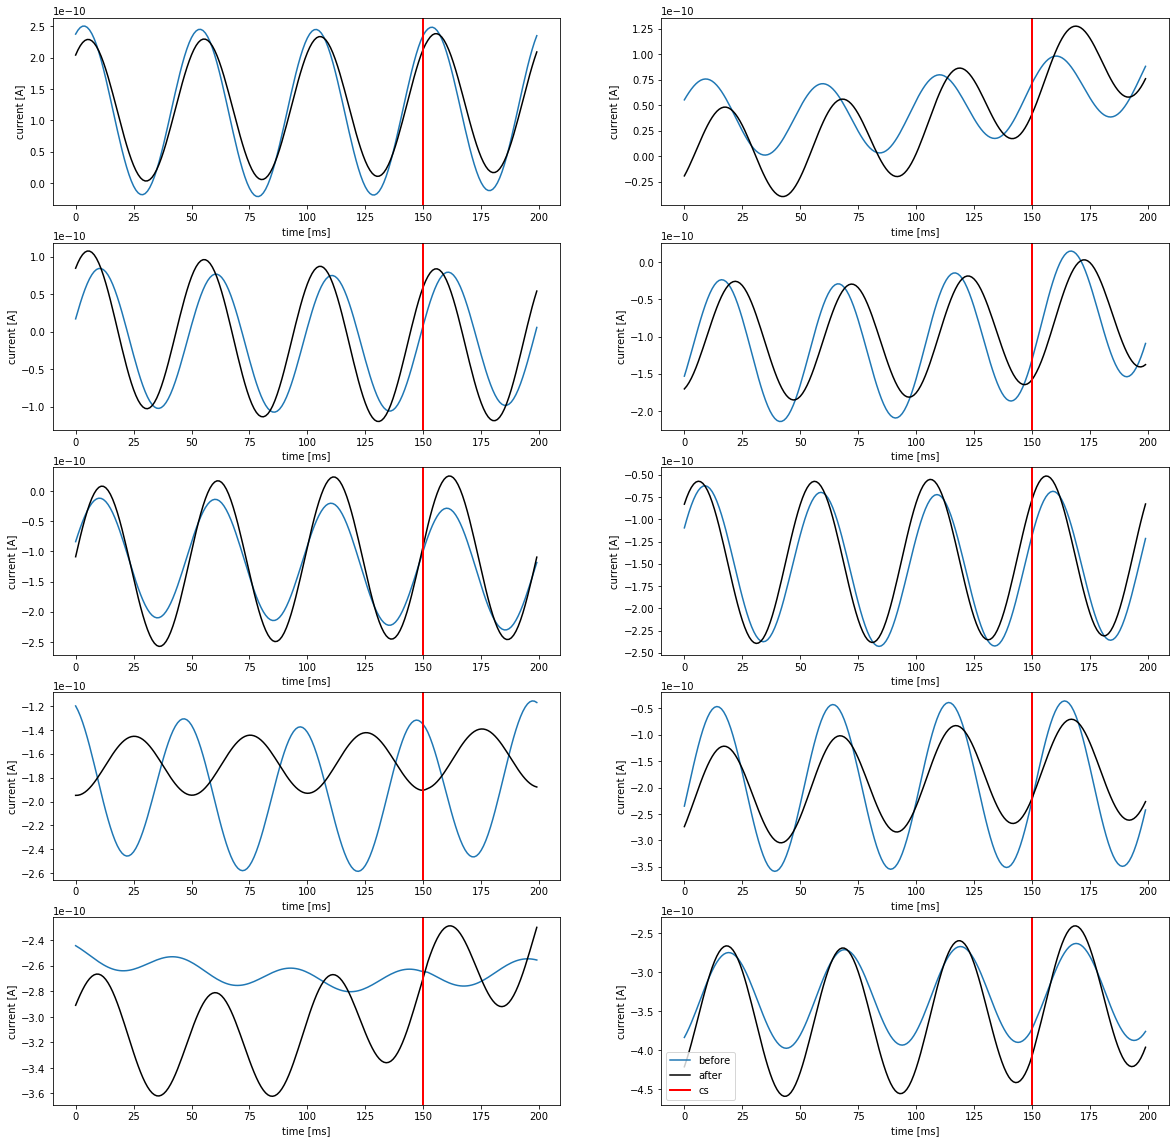

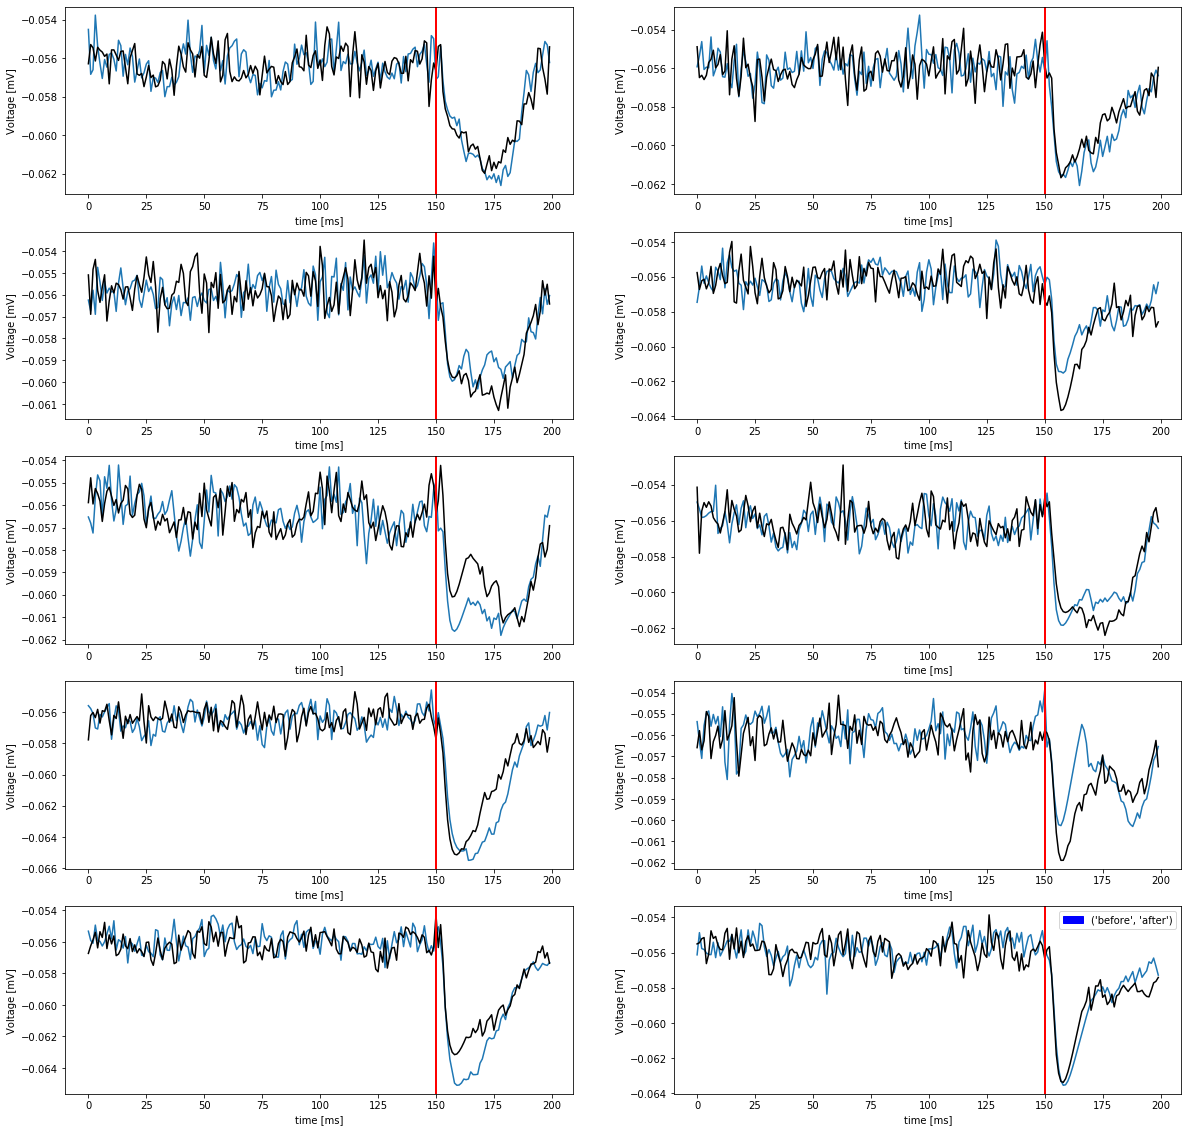

In [9]:
figure(figsize=(20,20))
for i in range(0,len(meancur_BA)):
    subplot(5,2,i+1)
    #print(meancur_AA[i])
    plot(meancur_BA[i])
    plot(meancur_AA[i],color='black')
    axvline(150, linewidth=2,color='r')
    xlabel('time [ms]')
    ylabel('current [A]')
legend(['before','after','cs'], loc='lower left')
show()
figure(figsize=(20,20))
for i in range(0,len(meancur_VBA)):
    subplot(5,2,i+1)
    #print(meancur_AA[i])
    plot(meancur_VBA[i])
    plot(meancur_VAA[i],color='black')
    axvline(150, linewidth=2,color='r')
    xlabel('time [ms]')
    ylabel('Voltage [mV]')


red_patch = mpatches.Patch(color='blue', label=('before','after'))
legend(handles=[red_patch])
show()